# Comparison of Single Phase Diagam Points

## Finding best metric to evaluate complexity in input distribution

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Imports for curve fitting
from iminuit import Minuit
from scipy.integrate import quad

In [3]:
# Keras imports
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
def load_dataset(a, b):
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if (alpha == a and beta == b) or (alpha == a and beta == 1-b):
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [5]:
Xmf, ymf, file_indexmf = load_dataset(0.2, 0.2)

Xmf_train, Xmf_test, ymf_train, ymf_test = train_test_split(Xmf, ymf, test_size=0.2)


Alpha, Beta is (0.2, 0.2) and given label 1
Alpha, Beta is (0.2, 0.8) and given label 2


In [6]:
class VAE:
    #
    def __init__(self, original_dim=100, intermediate_dim1=75, intermediate_dim2=50, latent_dim=1):
        #
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim1 = intermediate_dim1
        self.intermediate_dim2 = intermediate_dim2
        
    def sampling(self, args):
        # Unpack arguments
        z_mean, z_log_var = args
        # Get shape of random noise to sample
        epsilon = K.random_normal(shape=K.shape(z_mean))
        # Return samples from latent space p.d.f.
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def build_vae(self):
        #
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim1 = self.intermediate_dim1
        intermediate_dim2 = self.intermediate_dim2
        
        # encoder
        inputs = Input(original_dim, name='input')
        x = Dense(intermediate_dim1, activation='relu')(inputs)
        x = Dense(intermediate_dim2, activation='relu')(x)
        z_mean = Dense(latent_dim, name="z_mean")(x)
        z_log_var = Dense(latent_dim, name="z_log_var")(x)
        z = Lambda(self.sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        #decoder
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim2, activation='relu')(latent_inputs)
        x = Dense(intermediate_dim1, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        
        i = self.encoder.inputs
        if len(i) == 1:
            i = i[0]
            pass
        z = self.encoder(i)[2]
        o = self.decoder(z)
        self.vae = Model(i, o, name='VAE')
        
    def compile_vae(self):
        # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
        encoder   = self.vae.get_layer('encoder')
        z_log_var = encoder.get_layer('z_log_var').output
        z_mean    = encoder.get_layer('z_mean').output

        # Define reconstruction loss
        def reco_loss(y_true, y_pred):
            # Use binary cross-entropy loss
            reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
            reco_loss_value = K.sum(reco_loss_value)
            return reco_loss_value

        # Define Kullback-Leibler loss with reference to encoder output layers
        def kl_loss(y_true, y_pred):
            kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
            kl_loss_value = K.sum(kl_loss_value, axis=-1)
            return kl_loss_value

        # Define VAE loss
        def vae_loss(y_true, y_pred):
            return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

        self.vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
        return
    
    def get_summaries(self):
        #
        return [self.encoder.summary(),
                self.decoder.summary(),
                self.vae.summary()]
    
    def get_architectures(self):
        #
        return [plot_model(self.encoder, show_shapes=True),
                plot_model(self.decoder, show_shapes=True),
                plot_model(self.vae, show_shapes=True)]

In [7]:
MFvae = VAE()
MFvae.build_vae()
MFvae.compile_vae()

In [8]:
nb_epochs  = 10
batch_size = 32

In [9]:
mf_history = MFvae.vae.fit(Xmf_train, Xmf_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25088/25600 [============================>.] - ETA: 0s - loss: 19.6501 - reco_loss: 19.3848 - kl_loss: 0.2653- ETA: 1s - loss: 19.9148 - reco_loss: 19.7517 - kl_lo - ETA: 0s - loss: 19.7974 - reco_loss: 19.5891 - 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25600/25600 [==============================] - 3s 132us/sample - loss: 19.6412 - reco_loss: 19.3731 - kl_loss: 0.2681 - val_loss: 19.3699 - val_reco_loss: 18.9473 - val_kl_loss: 0.4226
Epoch 2/10
25600/25600 [==============================] - 3s 98us/sample - loss: 19.0808 - reco_loss: 18.5267 - kl_loss: 0.5541 - val_loss: 18.9884 - val_reco_loss: 18.3498 - val_kl_loss: 0.6386
Epoch 3/10
25600/25600 [==============================] - 3s 101us/sample - loss: 18.8821 - reco_loss: 18.1743 - kl_loss: 0.7077 - val_loss: 18.8458 - val_reco_loss: 18.0619 - val_kl_loss: 0.7840
Epoch 4/10
25600/25600 [==============================] - 3s 100us/sample - loss: 18.8121 - reco_loss: 18.0733 - kl_loss: 0.7388 - val_loss: 18.8520 - val_reco_loss: 18.0931 - val_kl_loss: 0.7590
Epoch 5/10
25600/25600 [==============================] - 3s 106us/sample - loss: 18.7762 - reco_loss: 18.0063 - kl_loss: 0.7698 - val_loss: 18.8527 - val_reco_loss: 18.0384 - val_kl_loss: 0.8144
Epoch 6/10
25600/25600 [========

In [10]:
def plot_losses(vae_history, name, ax):
    #
    ax.plot(vae_history.history['loss'], label= name+' training loss')
    ax.plot(vae_history.history['reco_loss'], label=name+' training reconstruction loss')
    #ax.plot(vae_history.history['kl_loss'], label=name+' training kl loss')
    ax.plot(vae_history.history['val_loss'], label=name+' validation loss')
    ax.plot(vae_history.history['val_reco_loss'], label=name+' validation reconstruction loss')
    #ax.plot(vae_history.history['val_kl_loss'], label=name+' validation kl loss')
    ax.legend(loc="best")

In [11]:
def plot_z_distribution(z_samples, fit_mu, fit_sigma, name, ax):
    #
    counts, bin_edges, _ = ax.hist(z_samples[:, 0],bins=50, density=True, label=name+' z samples')
    tot_bin_edges = np.array(bin_edges)
    half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
    zs = (tot_bin_edges + half_bin_width)[:-1]
    ax.plot(zs, gaussian_pdf(zs, fit_mu, fit_sigma), label=name+' Gaussian fit')
    ax.legend(loc="best")

In [12]:
def plot_z_example(z, decoder, name, ax):
    #
    ax.scatter(list(range(100)), decoder.predict(np.array([z])), label=name+' z = '+str(z))
    ax.set_ylim(0, 1)
    ax.legend()

In [13]:
def gaussian_pdf(z, mu, sigma):
    #
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((z - mu)/sigma)**2)

In [14]:
def nllmf(mu, sigma):
    #
    return -1 * np.sum(np.log(gaussian_pdf(mfz_samples, mu, sigma)))

In [15]:
def nllcx(mu, sigma):
    #
    return -1 * np.sum(np.log(gaussian_pdf(cxz_samples, mu, sigma)))

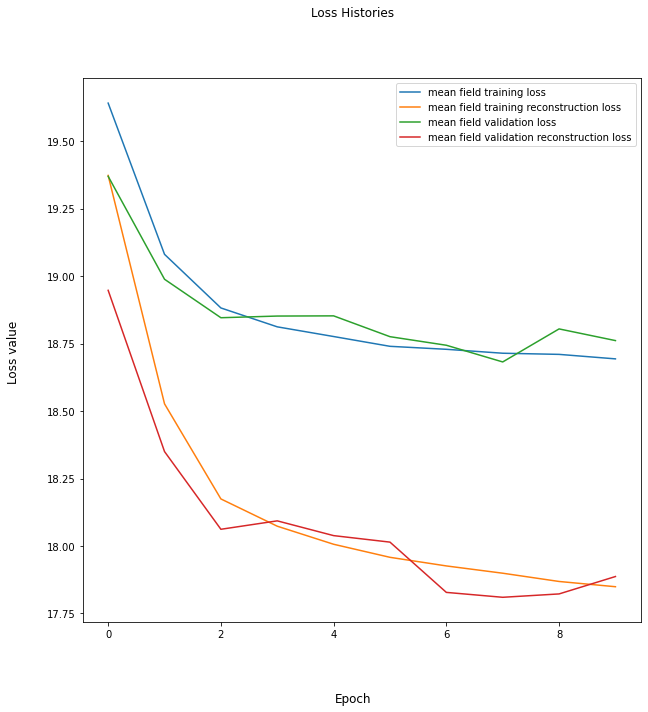

In [16]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10,10))
fig.suptitle('Loss Histories')
fig.supxlabel('Epoch')
fig.supylabel('Loss value')
plot_losses(mf_history, 'mean field', axs)

In [17]:
_, _, mfz_samples = MFvae.encoder.predict(Xmf_test)

In [18]:
# fit Minuit, with initial guesses for background lifetime, signal mean and background fraction F
fitmf = Minuit(nllmf, mu=0., sigma=1.)
# definition of error for nll given in notes
fitmf.errordef = 0.5

In [19]:
fitmf.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.179e+04                  │              Nfcn = 65               │
│ EDM = 0.000509 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   0.118   │   0.012   │            │            │         │         │       │
│ 1 │ sigma │   1.056   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000148        0 │
│ sigma │        0  5.9e-05 │
└───────┴───────────────────┘

In [20]:
mu_fitmf = fitmf.values["mu"]
sigma_fitmf = fitmf.values["sigma"]
fig, axs = plt.subplots(1, 1, figsize=(12,6))
fig.suptitle('z distributions')
fig.supxlabel('z')
fig.supylabel('probability density')
plot_z_distribution(mfz_samples, mu_fitmf, sigma_fitmf, 'mean field', axs)

NameError: name 'fitcx' is not defined

<span style="color:red">
    Used Minuit to carry out a maximum likelihood (minimum negative log-likelihood) assuming Gaussian form of both z-distributions. Left is for point on mean field line and fit is best. Right is for point on coexistance line and distribution has slight skewness so Gaussian fit is less good. In both cases the best estimate mean and sigma are about 0 and 1 respectively as expected.
</span>

In [54]:
print('Final validation KL-divergences to standard Gaussian')
print('Mean field: ',mf_history.history['val_kl_loss'][-1])
print('Coexistence: ',cx_history.history['val_kl_loss'][-1])

Final validation KL-divergences to standard Gaussian
Mean field:  0.0001433713
Coexistence:  1.1632175


<span style="color:red">
    First possible metric is final KL-divergence between z-distribution of training data encodings and the standard Gaussian (mean=0 standard deviation=1). Smaller KL-divergence should imply there is less diversity in the input data ie the network doesn't have much to learn about features of the input data. Here the KL-divergence for the MF point is much less than for the CX point which indicates there is some feature diversity in the CX point ie the shock can be at any point on the lattice.
</span>

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


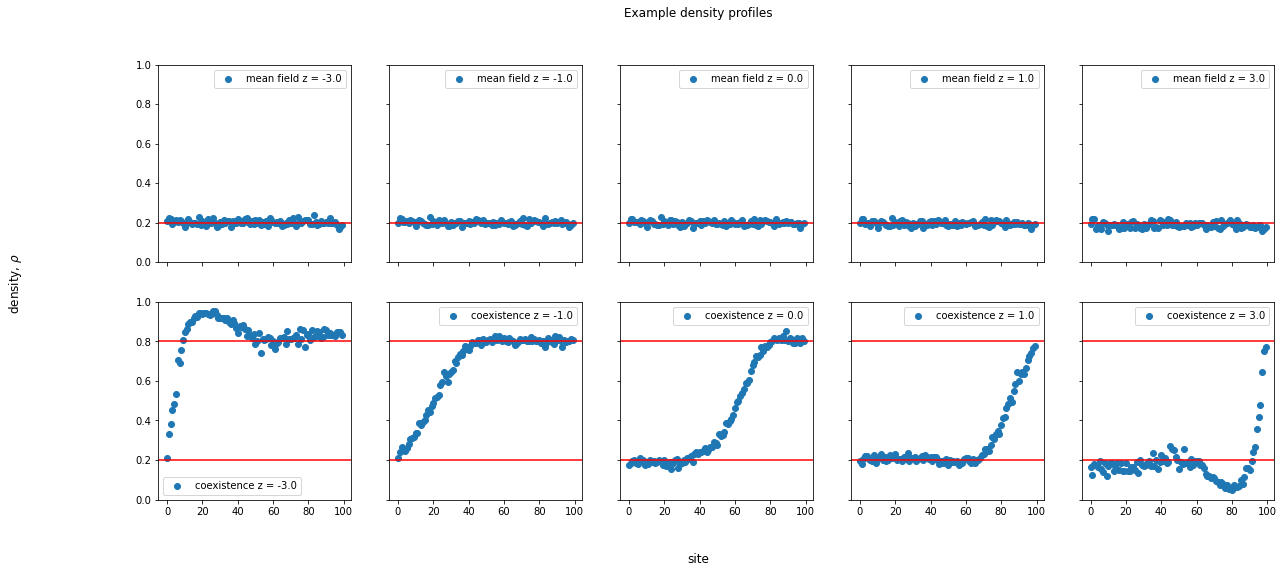

In [55]:
example_zs = np.array([-3., -1., 0., 1., 3.])
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,8))
fig.suptitle('Example density profiles')
fig.supxlabel('site')
fig.supylabel('density, '+r'$\rho$')
mfrho = 0.2
cxrho1 = 0.2
cxrho2 = 1. - cxrho1

for i in range(len(example_zs)):
    plot_z_example(example_zs[i], MFvae.decoder, 'mean field', axs[0, i])
    axs[0, i].axhline(y=mfrho, color='r', linestyle='-')
    plot_z_example(example_zs[i], CXvae.decoder, 'coexistence', axs[1, i])
    axs[1, i].axhline(y=cxrho1, color='r', linestyle='-')
    axs[1, i].axhline(y=cxrho2, color='r', linestyle='-')

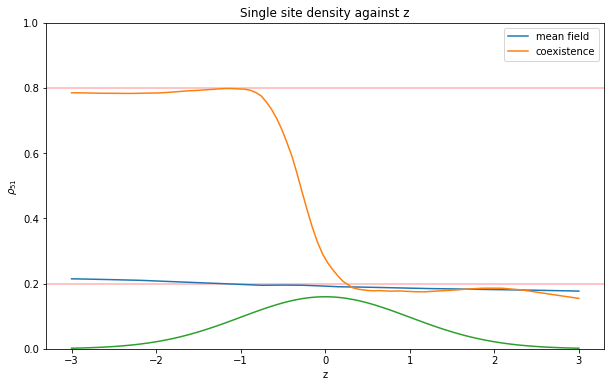

In [76]:
site = 51
zs_array = np.linspace(-3., 3., 100)
mfrhois = MFvae.decoder.predict(zs_array)
cxrhois = CXvae.decoder.predict(zs_array)

plt.figure(figsize=(10,6))
plt.axhline(y=cxrho1, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=cxrho2, color='r', linestyle='-', alpha=0.3)
plt.plot(zs_array, mfrhois[:, site-1], label='mean field')
plt.plot(zs_array, cxrhois[:, site-1], label='coexistence')
plt.plot(zs_array, 0.4*gaussian_pdf(zs_array, 0., 1.))
plt.ylim(0, 1)
plt.title('Single site density against z')
plt.ylabel(r'$\rho_{51}$')
plt.xlabel('z')
plt.legend(loc='best')
plt.show()

<span style="color:red">
    Here's the variance of a site in the middle of the lattice ($i=51$ out of length 100). The green curve shows the spead of a standard Gaussian (The height is arbitrary and it's not a density, only there to show the z-values where encodings are likely to be made). The Blue curve is for the MF point and we see for any z within one sigma of 0 it is correctly 0.2 while on the extremes of the distribution, it deviates slightly from the expected density of the training data. For the CX point, z one standard deviation either side of 0 $i=51$ is well into the low or high density part while for around $z=0$ the shock is around $i=51$.
</span>

In [77]:
truemfrhois = MFvae.decoder.predict(mfz_samples)
truecxrhois = CXvae.decoder.predict(cxz_samples)

In [79]:
mfvar = np.mean((truemfrhois[:, site-1] - np.mean(truemfrhois[:, site-1]))**2)
mfvar

4.0042316e-05

In [80]:
np.var(truemfrhois, axis=0)[site-1]

4.00423e-05

In [81]:
mfvar = np.var(truemfrhois, axis=0)
cxvar = np.var(truecxrhois, axis=0)

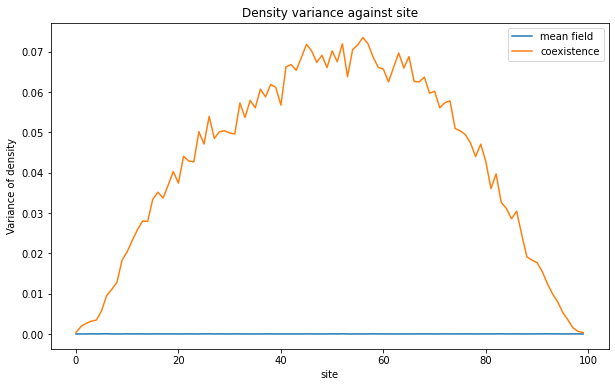

In [82]:
plt.figure(figsize=(10,6))
plt.plot(list(range(100)), mfvar, label='mean field')
plt.plot(list(range(100)), cxvar, label='coexistence')
plt.title('Density variance against site')
plt.ylabel('Variance of density')
plt.xlabel('site')
plt.legend(loc='best')
plt.show()

<span style="color:red">
    Variance in the density across encodings for the test data set against lattice site. For the MF point, there is little variation in the density of any site on the lattice as expected. For the CX point, density also doesn't vary much at the edges of the lattice as these points are almost always on one particular side of the shock. For the middle of the lattice we see highest variance as it is equally probable that the shock is on either side so is equally likely to be on the low or high density phase side so has a higher expected deviation from the mean density of $\approx0.5$
</span>